# `DSML Team 69` - Philadelphia, 2018-2020

Contributors:
- Diyar Apaydin
- Julian Stricker 
- Kesheng Guo

In the following code, all the Python libraries required by the Jupyter Notebook are imported 

In [1]:
import pandas as pd
from datetime import date, time, datetime, timedelta
from dateutil.parser import parse
import json
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import numpy as np
pd.set_option('display.max_columns', None)
import folium
from folium import plugins
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from matplotlib import dates
from matplotlib.lines import Line2D
from haversine import haversine
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


The following section provides links to all the data used:

All the information is either sourced from [rideindego](https://www.rideindego.com/about/data/) or provided by the instructors via [sciebo](https://uni-koeln.sciebo.de/s/ZOdCfXORDTeGnlF).

- More Information about the Stations: https://www.rideindego.com/wp-content/uploads/2023/04/indego-stations-2023-04-01.csv (from: 2023-04-01).

- Live-Station Information: https://bts-status.bicycletransit.workers.dev/phl (from: 2023-07-04).

- Add the file extension '.csv' to all files except the Live-Station Information, which should have the '.json' extension.

## `1. Data Collection and Preparation`

Reading in all the required files:

In [2]:
bike_rentals = pd.read_csv("indego_2018_2020.csv",sep =",",low_memory=False)

station_set = pd.read_csv('indego-stations-2023-04-01.csv',sep=",",usecols=['Station_ID', 'Station_Name','Day of Go_live_date','Status'])

weather = pd.read_csv('Philadelphia.csv',sep=',',low_memory=False)

poi_penn = pd.read_csv('Pennsylvania_POIs.csv',sep=',',low_memory=False)

philiadelphia_poi = poi_penn[poi_penn['addr:city'] == 'Philadelphia']

poi_nj = pd.read_csv('NewJersey_POIs.csv',sep=',',low_memory=False)

with open('phl_station.json') as file:
    
    data = json.load(file)


FileNotFoundError: [Errno 2] No such file or directory: 'phl_station.json'

In [ ]:
bike_rentals.rename(columns={'Unnamed: 0': 'trip_id'}, inplace=True)

Removing all rows with Bike_IDs that are not numerical and converting the remaining ones to the 'int' data type.

In [ ]:
bike_rentals = bike_rentals[pd.to_numeric(bike_rentals['bike_id'],errors="coerce").notnull()]

bike_rentals['bike_id'] = bike_rentals['bike_id'].astype(int)

bike_rentals = bike_rentals[['bike_id','start_time','start_station_id','start_station_lat','start_station_lon','end_time','end_station_id','end_station_lat','end_station_lon']]

Obtaining the exact longitude and latitude of stations from the Live-Station JSON file and adding them to the Station Table.

In [ ]:
station_coords = {}

for feature in data['features']:

    station_id = feature['properties']['id']

    latitude = feature['properties']['latitude']

    longitude = feature['properties']['longitude']

   
    station_coords[station_id] = {'latitude': latitude, 'longitude': longitude}

def get_coords(station_id):

    if station_id in station_coords:

        return station_coords[station_id]
    
    else:

        return {'latitude': None, 'longitude': None}
    
coords = station_set['Station_ID'].apply(get_coords)

station_set['Latitude'] = coords.apply(lambda x: x['latitude'])

station_set['Longitude'] = coords.apply(lambda x: x['longitude'])


Deleting all stations that did not exist until 2020.

In [ ]:
station_set['Day of Go_live_date'] = pd.to_datetime(station_set['Day of Go_live_date'], format='%m/%d/%Y')

In [ ]:
station_set = station_set[station_set['Day of Go_live_date'].dt.year <=2020]

Converting Start- and End-Station-ID to int

In [ ]:
bike_rentals['start_station_id'] = bike_rentals['start_station_id'].astype(int)

bike_rentals['end_station_id'] = bike_rentals['end_station_id'].astype(int)

Converting 'start_time' and 'end_time' to valid datetime object

In [ ]:
bike_rentals['start_time'] = pd.to_datetime(bike_rentals['start_time'], format=  'Date: %d/%m/%y; Time: %H:%M:%S',errors='coerce')

bike_rentals = bike_rentals[bike_rentals['start_time'].notna()]
bike_rentals['end_time'] = pd.to_datetime(bike_rentals['end_time'], format=  'Date: %d/%m/%y; Time: %H:%M:%S',errors='coerce')

bike_rentals = bike_rentals[bike_rentals['end_time'].notna()]

The chosen method for calculating Idle Time is Station-based. This decision is based on our focus on assessing Station Usage. If we were to calculate the Idle Time for each individual Bike, certain Bikes might be in unfavorable positions, leading to inaccuracies in the idle time measurement.

In [ ]:
drop_df = bike_rentals[['bike_id','end_station_id', 'end_time','end_station_lat','end_station_lon']].rename(columns={'end_station_id': 'station_id', 'end_time': 'timestamp','end_station_lat': 'lat'  ,'end_station_lon': 'lon'})
drop_df['event'] = 'drop'

pick_df = bike_rentals[['bike_id','start_station_id', 'start_time','start_station_lat','start_station_lon']].rename(columns={'start_station_id': 'station_id', 'start_time': 'timestamp','start_station_lat': 'lat'  ,'start_station_lon': 'lon'  })
pick_df['event'] = 'pick'

total_rentals = bike_rentals.copy()
bike_rentals = pd.concat([drop_df, pick_df])

bike_rentals.sort_values(by=['station_id', 'timestamp'], inplace=True)

Remove Virtual Station used by Employees

In [ ]:
bike_rentals = bike_rentals[bike_rentals['station_id'] != 3000]
total_rentals = total_rentals[total_rentals['start_station_id'] != 3000]
total_rentals = total_rentals[total_rentals['start_station_id'] != 3000]

Remove Non-existing Stations

In [ ]:
total_rentals = total_rentals[total_rentals['start_station_id'].isin(station_set['Station_ID'])]
total_rentals = total_rentals[total_rentals['start_station_id'].isin(station_set['Station_ID'])]
bike_rentals = bike_rentals[bike_rentals['station_id'].isin(station_set['Station_ID'])]

Create Columns which contains for each row the information of previous Event at Station

In [ ]:
bike_rentals['next_event'] = bike_rentals.groupby(['station_id'])['event'].shift(-1)
bike_rentals['next_timestamp'] = bike_rentals.groupby(['station_id'])['timestamp'].shift(-1)

In [ ]:
bike_rentals = bike_rentals.dropna(axis=0)

We are Interested in the Time between Drop-off and Pick-up. We are removing Events of same kind which happens back to back

In [ ]:
bike_rentals = bike_rentals[((bike_rentals['event'] == 'drop') & (bike_rentals['next_event'] == 'pick')) ]


Calculate Idle Time

In [ ]:
bike_rentals['idle_time'] = bike_rentals['next_timestamp'] - bike_rentals['timestamp']

In [ ]:
bike_rentals['idle_time'].describe()

Renaming columns and remove no more needed columns

In [ ]:
bike_rentals = bike_rentals.drop(columns=['event','timestamp'], axis=1)


bike_rentals = bike_rentals.rename(columns={'next_timestamp': 'timestamp', 'next_event':'event'})

Rideindego suggests: 

"Data will be cleansed prior to publication according to the following criteria:

- Staff servicing and test trips are removed.

- Trips below 1 minute are removed.

- A “Virtual Station” listed in the checkout and return kiosks, is used by staff to check in or check out a bike remotely for a special event or in a situation in which a bike could not otherwise be checked in or out to a station.

- Trip lengths are capped at 24 hours.

- Some short round trips or long trips may be the result of system or user error, but have been kept in the dataset for completeness."

Convert the start_time and end_time columns to datetime format

According to RideIndego:
- Trips below 1 minute are removed.

- Trip lengths are capped at 24 hours.

- Some short round trips or long trips may be the result of system or user error, but have been kept in the dataset for completeness.

Creation of the feature 'duration'.


In [ ]:
total_rentals['duration'] = total_rentals['end_time'] - total_rentals['start_time']

In [ ]:
def get_date(ts):
    return ts.date()

def get_weekday(ts):
    return ts.weekday()

def get_hour(ts):
    return ts.hour

def get_month(ts):
    return ts.month

def get_year(ts):
    return ts.year

Time-based feature engineering.

In [ ]:
bike_rentals.loc[:, "Date"] = bike_rentals["timestamp"].apply(lambda x: get_date(x))
bike_rentals.loc[:, "Weekday"] = bike_rentals["timestamp"].apply(lambda x: get_weekday(x))
bike_rentals.loc[:, "Hour"] = bike_rentals["timestamp"].apply(lambda x: get_hour(x))
bike_rentals.loc[:, 'Month'] = bike_rentals["timestamp"].apply(lambda x: get_month(x))
bike_rentals.loc[:, 'Weekend'] = bike_rentals['Weekday'].apply(lambda x: 1 if x >= 5 else 0)  # 5 and 6 corresponds to Sat and Sun
bike_rentals.loc[:, 'Year'] = bike_rentals['timestamp'].apply(lambda x: get_year(x))
total_rentals["Date"] = total_rentals["start_time"].apply(lambda x: get_date(x))
total_rentals["Weekday"]=total_rentals["start_time"].apply(lambda x: get_weekday(x))
total_rentals["Hour"]=total_rentals["start_time"].apply(lambda x: get_hour(x))
total_rentals['Month'] = total_rentals["start_time"].apply(lambda x: get_month(x))
total_rentals['Weekend'] = total_rentals['Weekday'].apply(lambda x: 1 if x >= 5 else 0)  # 5 and 6 corresponds to Sat and Sun
total_rentals['Year'] = total_rentals['start_time'].apply(lambda x: get_year(x))

Remove duplicates

In [ ]:
bike_rentals = bike_rentals.drop_duplicates()
total_rentals = total_rentals.drop_duplicates()

A bike must be picked up at the same station where it was dropped off.

In [ ]:
bike_rentals['season'] = bike_rentals['Month'].apply(lambda x: {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
}[x])
total_rentals['season'] = total_rentals['Month'].apply(lambda x: {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
}[x])

Creation of a unified coordinate for each Station. We are using the most common lat and lon for a Station ID.

In [ ]:
# Calculate the most frequent lat, lon for each station
def most_frequent_lat_lon(data):
    if len(data.value_counts()) > 0:
        return data.value_counts().index[0]
    else:
        return np.nan

frequent_coords = bike_rentals.groupby('station_id')[['lat', 'lon']].agg(most_frequent_lat_lon)


bike_rentals.loc[:, 'lat'] = bike_rentals.groupby('station_id')['lat'].transform(lambda data: data.fillna(frequent_coords.loc[data.name, 'lat']))
bike_rentals.loc[:, 'lon'] = bike_rentals.groupby('station_id')['lon'].transform(lambda data: data.fillna(frequent_coords.loc[data.name, 'lon']))


grouped_coordinates = bike_rentals.groupby('station_id')[['lat', 'lon']].nunique()
inconsistent_stations = grouped_coordinates[(grouped_coordinates['lat'] > 1) | (grouped_coordinates['lon'] > 1)]


for idx in inconsistent_stations.index:
    bike_rentals.loc[bike_rentals['station_id'] == idx, ['lat', 'lon']] = frequent_coords.loc[idx].values

In [ ]:
# First calculate the most common lat, lon for each station
def most_common(x):
    if len(x.value_counts()) > 0:
        return x.value_counts().index[0]
    else:
        return np.nan

common_coords = total_rentals.groupby('start_station_id')[['start_station_lat', 'start_station_lon']].agg(most_common)


total_rentals['start_station_lat'] = total_rentals.groupby('start_station_id')['start_station_lat'].transform(lambda x: x.fillna(common_coords.loc[x.name, 'start_station_lat']))
total_rentals['start_station_lon'] = total_rentals.groupby('start_station_id')['start_station_lon'].transform(lambda x: x.fillna(common_coords.loc[x.name, 'start_station_lon']))


grouped = total_rentals.groupby('start_station_id')[['start_station_lat', 'start_station_lon']].nunique()
inconsistent_stations = grouped[(grouped['start_station_lat'] > 1) | (grouped['start_station_lon'] > 1)]


for idx in inconsistent_stations.index:
    total_rentals.loc[total_rentals['start_station_id'] == idx, ['start_station_lat', 'start_station_lon']] = common_coords.loc[idx].values

In [ ]:

common_end_coords = total_rentals.groupby('end_station_id')[['end_station_lat', 'end_station_lon']].agg(most_common)


total_rentals['end_station_lat'] = total_rentals.groupby('end_station_id')['end_station_lat'].transform(lambda x: x.fillna(common_end_coords.loc[x.name, 'end_station_lat']))
total_rentals['end_station_lon'] = total_rentals.groupby('end_station_id')['end_station_lon'].transform(lambda x: x.fillna(common_end_coords.loc[x.name, 'end_station_lon']))


grouped_end = total_rentals.groupby('end_station_id')[['end_station_lat', 'end_station_lon']].nunique()
inconsistent_end_stations = grouped_end[(grouped_end['end_station_lat'] > 1) | (grouped_end['end_station_lon'] > 1)]


for idx in inconsistent_end_stations.index:
    total_rentals.loc[total_rentals['end_station_id'] == idx, ['end_station_lat', 'end_station_lon']] = common_end_coords.loc[idx].values

Use the "Haversine formula" to calculate the distance traveled. That's only the Distance between Stations, the rider could have stops somewhere else or take detours. 

In [ ]:
import numpy as np

# Convert latitude and longitude to radians
start_lat_rad = np.radians(total_rentals['start_station_lat'])
start_lon_rad = np.radians(total_rentals['start_station_lon'])
end_lat_rad = np.radians(total_rentals['end_station_lat'])
end_lon_rad = np.radians(total_rentals['end_station_lon'])

# Differences
diff_lat = end_lat_rad - start_lat_rad
diff_lon = end_lon_rad - start_lon_rad

# Apply the Haversine formula
a = np.sin(diff_lat / 2.0)**2 + np.cos(start_lat_rad) * np.cos(end_lat_rad) * np.sin(diff_lon / 2.0)**2
c = 2 * np.arcsin(np.sqrt(a))

# Radius of Earth in kilometers
R = 6371.0
total_rentals['distance_travelled (km)'] = R * c

Remove trips that start or end outside of the bounds of Philadelphia

In [ ]:
philly_lat_min = 39.7
philly_lat_max = 40.5
philly_lon_min = -76.2
philly_lon_max = -73.8
total_rentals = total_rentals[
    (total_rentals['start_station_lat'].between(philly_lat_min, philly_lat_max)) &
    (total_rentals['start_station_lon'].between(philly_lon_min, philly_lon_max)) |
    (total_rentals['end_station_lat'].between(philly_lat_min, philly_lat_max)) &
    (total_rentals['end_station_lon'].between(philly_lon_min, philly_lon_max))
]
philly_lat_min = 39.7
philly_lat_max = 40.5
philly_lon_min = -76.2
philly_lon_max = -73.8
bike_rentals = bike_rentals[
    (bike_rentals['lat'].between(philly_lat_min, philly_lat_max)) &
    (bike_rentals['lon'].between(philly_lon_min, philly_lon_max)) 
]

Rent-duration:

In [ ]:
total_rentals['duration'] = total_rentals['end_time'] - total_rentals['start_time']

According to RideIndego:
- Trips below 1 minute are removed.

- Trip lengths are capped at 24 hours.

- Some short round trips or long trips may be the result of system or user error, but have been kept in the dataset for completeness.

In [ ]:
total_rentals = total_rentals[((total_rentals['duration'].dt.total_seconds() / 60) >= 1) & ((total_rentals['duration'].dt.total_seconds() / 60 / 60) <= 24)]

Weather-Data cleaning:

Converting to Datetime Object and standard cleaning process

In [ ]:
weather['timestamp'] = pd.to_datetime(weather['timestamp'], errors='coerce')
weather = weather.dropna(axis=0)
weather = weather[(weather['timestamp'].dt.year >= 2018) & (weather['timestamp'].dt.year <= 2020)]
weather.describe()

Summarise Cloud Cover Description to a more simple one

In [ ]:
def summarise_cloud_desc(desc):
    if 'Cloudy' in desc:
        return 'Cloudy'
    elif 'Rain' in desc or 'Drizzle' in desc:
        return 'Rain'
    elif 'Snow' in desc or 'Sleet' in desc or 'Wintry Mix' in desc:
        return 'Snow'
    elif 'Fog' in desc or 'Haze' in desc or 'Mist' in desc:
        return 'Fog'
    elif 'Thunder' in desc or 'T-Storm' in desc:
        return 'Thunder'
    elif 'Windy' in desc or 'Squalls' in desc:
        return 'Windy'
    else:
        return 'Fair'

In [ ]:
weather['weather_summary'] = weather['cloud_cover_description'].apply(summarise_cloud_desc)

Feature Enginnering

In [ ]:

weather.dropna(axis = 0,inplace=True)
weather['severity'] = (weather['temperature'] + weather['windspeed'] + weather['precipitation'])/3
weather['isRaining'] = weather['precipitation'].apply(lambda x: 1 if x > 0 else 0)
weather['cloud_cover_description'] = pd.Categorical(weather['cloud_cover_description'])
weather['temperature_diff'] = weather['temperature'] - weather['felt_temperature']

In [ ]:
total_rentals.sort_values(by=['start_time'],inplace=True)

In [ ]:
total_rentals['Date'] = pd.to_datetime(total_rentals['Date'])

In [ ]:
len(total_rentals)

Round Weather to whole Hour. Assuming that 6min difference doesnt have a affect. To do a better merging later

In [ ]:
weather['rounded_timestamp'] = weather['timestamp'].dt.round('H')
weather = weather.drop_duplicates(subset='rounded_timestamp', keep='first')
total_rentals['rounded_timestamp']  = total_rentals['start_time'].dt.round('H')

In [ ]:
total_rentals = total_rentals.sort_values('start_time')
weather = weather.sort_values('timestamp')

total_rentals= pd.merge(total_rentals, weather, left_on='rounded_timestamp'  , right_on='rounded_timestamp', how= 'inner')



In [ ]:
total_rentals = total_rentals.drop(columns=['rounded_timestamp','timestamp'])

In [ ]:
bike_rentals['rounded_timestamp'] = bike_rentals['timestamp'].dt.round('H')

In [ ]:
bike_rentals['Date'] = pd.to_datetime(bike_rentals['Date'])

bike_rentals.sort_values(by=['rounded_timestamp'], inplace=True)
weather.sort_values(by=['rounded_timestamp'], inplace=True)

final = pd.merge(bike_rentals, weather, on='rounded_timestamp', how='inner')

In [ ]:
final = final.rename(columns={'timestamp_x': 'timestamp'})

In [ ]:
final = final.drop(columns=['rounded_timestamp','timestamp_y'])

In [ ]:
final = final.dropna(axis = 0)
total_rentals = total_rentals.dropna(axis = 0)

Final Dataframe for Idle Time

In [ ]:
final.info(show_counts = True)

In [ ]:
poi_nj = poi_nj[poi_nj['addr:city'] == 'Philadelphia']

In [ ]:
poi_penn = poi_penn[poi_penn['addr:city'] == 'Philadelphia']

In [ ]:
final = final.dropna(axis = 0)
total_rentals = total_rentals.dropna(axis = 0)

Idle Time in Float (minutes) is better to use

In [ ]:
final['idle_time'] = final['idle_time'].dt.total_seconds()/60

In [ ]:
poi_names = ['Liberty Bell', 'The Porch at 30th Street Station', 'Hawthorn Suites by Wyndham Philadelphia Airport', 'Independence Hall', 'Philadelphia Museum of Art', 'University of Pennsylvania', 'Temple University', 'Philadelphia City Hall', 'Reading Terminal Market', 'Rittenhouse Square', 'Franklin Institute', 'Pennsylvania Convention Center', 'Citizens Bank' , 'Philadelphia Zoo', "Penn's Landing Operations and Visitor center"]

# Filter POI's
poi_penn = poi_penn[poi_penn['name'].isin(poi_names)]

# Filter Columns
poi_penn = poi_penn[['lat', 'lon', 'name', 'amenity']]

# Drop Duplicates
poi_penn = poi_penn.drop_duplicates(subset='name', keep='first')

# reset index
poi_penn = poi_penn.reset_index(drop=True)


# add missing lon and lat

# Independence Hall
poi_penn.loc[8, 'lat'] = 39.94887
poi_penn.loc[8, 'lon'] = -75.150026

# Philadelphia Museum of Art
poi_penn.loc[9, 'lat'] = 39.9655697
poi_penn.loc[9, 'lon'] = -75.1809661

# Pennsylvania Convention Center
poi_penn.loc[10, 'lat'] = 39.95510695
poi_penn.loc[10, 'lon'] = -75.1602358

# Reading Terminal Market
poi_penn.loc[11, 'lat'] = 39.9533369
poi_penn.loc[11, 'lon'] = -75.159009

# Franklin Institute
poi_penn.loc[12, 'lat'] = 39.95824385
poi_penn.loc[12, 'lon'] = -75.1730789

# Philadelphia Zoo
poi_penn.loc[13, 'lat'] = 39.97172805
poi_penn.loc[13, 'lon'] = -75.1959915

# Philadelphia City Hall
poi_penn.loc[14, 'lat'] = 39.9523995
poi_penn.loc[14, 'lon'] = -75.162989





In [ ]:
total_rentals.info(show_counts=True)

## `2. Descriptive Analytics`

Amount of Rentals for each year:

In [ ]:


df = total_rentals.copy()

grouped_data = df.groupby(['Year', 'Month']).size().reset_index(name='RentalCount')


years = grouped_data['Year'].unique()
num_years = len(years)

fig, ax = plt.subplots()


lines = []
for i in range(num_years):
    year_data = grouped_data[grouped_data['Year'] == years[i]]
    line, = ax.plot(year_data['Month'], year_data['RentalCount'], label=str(years[i]))
    lines.append(line)

ax.set_xlabel('Month')
ax.set_ylabel('Trips')
ax.set_title('Number of Rentals per Month (by Year)')


legend_colors = [Line2D([0], [0], color=line.get_color()) for line in lines]

ax.set_xlim(1, 12)


ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


ax.legend(legend_colors, [str(year) for year in years])


plt.show()

Average Idle Time over the day

In [ ]:

idle_time_hour = final.copy()
idle_time_hour = idle_time_hour.groupby('Hour')['idle_time'].mean().reset_index()
def format_time(x, pos=None):
    minutes = int(x)
    seconds = int((x - minutes) * 60)
    return f'{minutes:02d}:{seconds:02d}'

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('Idle Time (min)')
sns.barplot(data=idle_time_hour, x='Hour', y='idle_time', ax=ax)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlabel('Hour')
ax.set_ylabel('Idle Time (minutes)')
plt.title('Average Idle Time over the day')
plt.show()

In [ ]:
idle_time_hour_season = final.groupby([ 'season','Hour',])['idle_time'].mean().reset_index()


def format_time(x, pos=None):
    minutes = int(x)
    seconds = int((x - minutes) * 60)
    return f'{minutes:02d}:{seconds:02d}'


season_colors = {
    "Winter": "cyan",
    "Spring": "green",
    "Summer": "yellow",
    "Autumn": "red",
}


fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=idle_time_hour_season, x='Hour', y='idle_time', hue='season', ax=ax, palette=season_colors)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlabel('Hour')
ax.set_ylabel('Idle Time (minutes)')
plt.title('Average Idle Time over the day for each Season')
plt.show()

In [ ]:


idle_time_hour = final.groupby('Month')['idle_time'].mean().reset_index()


def format_time(x, pos=None):
    minutes = int(x)
    seconds = int((x - minutes) * 60)
    return f'{minutes:02d}:{seconds:02d}'

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=idle_time_hour, x='Month', y='idle_time', ax=ax)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlabel('Month')
ax.set_ylabel('Idle Time (minutes)')
plt.title('Average Idle Time per Month')
plt.show()


In [ ]:

idle_time_hour = final.groupby('season')['idle_time'].mean().reset_index()


def format_time(x, pos=None):
    minutes = int(x)
    seconds = int((x - minutes) * 60)
    return f'{minutes:02d}:{seconds:02d}'

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=idle_time_hour, x='season', y='idle_time', ax=ax)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlabel('Season')
ax.set_ylabel('Idle Time')
plt.title('Average Idle Time per Season')
plt.show()

In [ ]:

idle_time_hour_weekday = final.groupby(['Hour', 'Weekday'])['idle_time'].mean().reset_index()


palette = sns.color_palette("bright", 7) 


plt.figure(figsize=(12, 6))
sns.lineplot(data=idle_time_hour_weekday, x='Hour', y='idle_time', hue='Weekday', palette=palette)

ax.set_xlabel('Hour')
ax.set_ylabel('Idle Time')
plt.title('Average Idle Time per Hour for each Weekday')


weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [weekday_names[int(round(float(label)))] for label in labels]
plt.legend(handles, new_labels, title='Weekday', title_fontsize='13')

plt.show()

In [ ]:

idle_time_hour_weekday = final.groupby(['Hour', 'Weekend'])['idle_time'].mean().reset_index()


palette = sns.color_palette("bright", 2)  # 7 is the number of unique categories (days of the week)


plt.figure(figsize=(12, 6))
sns.lineplot(data=idle_time_hour_weekday, x='Hour', y='idle_time', hue='Weekend', palette=palette)


ax.set_xlabel('Hour')
ax.set_ylabel('Idle Time')
plt.title('Average Idle Time per Hour for Weekday/Weekend')


weekday_names = ['Weekday', 'Weekend']
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [weekday_names[int(round(float(label)))] for label in labels]
plt.legend(handles, new_labels, title='Weekday', title_fontsize='13')


In [ ]:


idle_time_per_day = final.groupby('Date')['idle_time'].mean()

fig, ax1 =plt.subplots(figsize=(15, 8))
final_temp = final.copy()


final_temp.groupby('Date')['temperature'].mean().plot(ax=ax1, color='blue')
ax1.set_ylabel('Temperature', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
idle_time_per_day.plot(ax=ax2, color='red', alpha=0.4)  
ax2.set_ylabel('Idle Time', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Temperature and Average Idle Time over Time')
plt.show()

In [ ]:

station_usage = total_rentals['start_station_id'].value_counts()

N = 10  
top_stations = station_usage.head(N)


legend_labels = []
for station_id in top_stations.index:
    station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    legend_labels.append(f'{station_id}: {station_name}')


sns.set(style='darkgrid')
colormap = sns.color_palette('bright', N)


fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)  # Adjust the margins as needed


top_stations.plot(kind='bar', ax=ax, color=colormap)


ax.set_xlabel('Station ID')
ax.set_ylabel('Usage')
ax.set_title('Top 10 Start Stations by Usage')


plt.xticks(rotation=0)


ax.grid(axis='y', linestyle='--')


for i, v in enumerate(top_stations.values):
    ax.text(i, v, str(v), ha='center', va='bottom')


legend_handles = []
for i, station_id in enumerate(top_stations.index):
    station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    legend_handle = plt.Line2D([0], [0], color=colormap[i], marker='s', markersize=8, label=f'{station_id}: {station_name}')
    legend_handles.append(legend_handle)

# Move the legend to the right side and increase the height
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), handleheight=2.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
station_usage = total_rentals['end_station_id'].value_counts()

N = 10  
top_stations = station_usage.head(N)


legend_labels = []
for station_id in top_stations.index:
    station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    legend_labels.append(f'{station_id}: {station_name}')


sns.set(style='darkgrid')
colormap = sns.color_palette('bright', N)


fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)  # Adjust the margins as needed


top_stations.plot(kind='bar', ax=ax, color=colormap)


ax.set_xlabel('Station ID')
ax.set_ylabel('Usage')
ax.set_title('Top 10 End Stations by Usage')


plt.xticks(rotation=0)


ax.grid(axis='y', linestyle='--')


for i, v in enumerate(top_stations.values):
    ax.text(i, v, str(v), ha='center', va='bottom')


legend_handles = []
for i, station_id in enumerate(top_stations.index):
    station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    legend_handle = plt.Line2D([0], [0], color=colormap[i], marker='s', markersize=8, label=f'{station_id}: {station_name}')
    legend_handles.append(legend_handle)

# Move the legend to the right side and increase the height
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), handleheight=2.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
station_usage = total_rentals['end_station_id'].value_counts()

N = 10  
top_stations = station_usage.tail(N)[::-1]


legend_labels = []
for station_id in top_stations.index:
    if station_set['Station_ID'].isin([station_id]).any():
        station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    else:
        station_name = 'Unknown Station'
    legend_labels.append(f'{station_id}: {station_name}')


sns.set(style='darkgrid')
colormap = sns.color_palette('bright', N)


fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)  # Adjust the margins as needed


top_stations.plot(kind='bar', ax=ax, color=colormap)


ax.set_xlabel('Station ID')
ax.set_ylabel('Usage')
ax.set_title('Top 10 End Stations by the least Usage')


plt.xticks(rotation=0)


ax.grid(axis='y', linestyle='--')


for i, v in enumerate(top_stations.values):
    ax.text(i, v, str(v), ha='center', va='bottom')


legend_handles = []
for i, station_id in enumerate(top_stations.index):
    if station_set['Station_ID'].isin([station_id]).any():
        station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    else:
        station_name = 'Unknown Station'
    legend_handle = plt.Line2D([0], [0], color=colormap[i], marker='s', markersize=8, label=f'{station_id}: {station_name}')
    legend_handles.append(legend_handle)


ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), handleheight=2.5)


plt.tight_layout()
plt.show()

In [ ]:

station_usage = total_rentals['start_station_id'].value_counts()

N = 10  
top_stations = station_usage.tail(N)[::-1]


legend_labels = []
for station_id in top_stations.index:
    if station_set['Station_ID'].isin([station_id]).any():
        station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    else:
        station_name = 'Unknown Station'
    legend_labels.append(f'{station_id}: {station_name}')


sns.set(style='darkgrid')
colormap = sns.color_palette('bright', N)


fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)  # Adjust the margins as needed


top_stations.plot(kind='bar', ax=ax, color=colormap)


ax.set_xlabel('Station ID')
ax.set_ylabel('Usage')
ax.set_title('Top 10 Start Stations by the least Usage')


plt.xticks(rotation=0)


ax.grid(axis='y', linestyle='--')


for i, v in enumerate(top_stations.values):
    ax.text(i, v, str(v), ha='center', va='bottom')


legend_handles = []
for i, station_id in enumerate(top_stations.index):
    if station_set['Station_ID'].isin([station_id]).any():
        station_name = station_set.loc[station_set['Station_ID'] == station_id, 'Station_Name'].values[0]
    else:
        station_name = 'Unknown Station'
    legend_handle = plt.Line2D([0], [0], color=colormap[i], marker='s', markersize=8, label=f'{station_id}: {station_name}')
    legend_handles.append(legend_handle)


ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), handleheight=2.5)


plt.tight_layout()
plt.show()


In [ ]:


total_rentals['duration (min)'] = total_rentals['duration'] / pd.Timedelta(minutes=1)


duration_range = range(1, 120) 


plt.figure(figsize=(12, 6))


counts, _, _ = plt.hist(total_rentals['duration (min)'], bins=duration_range, edgecolor='black', alpha=0.6, label='All Data')


weekend_counts, _, _ = plt.hist(total_rentals[total_rentals['Weekend'] == 1]['duration (min)'], bins=duration_range, edgecolor='black', alpha=0.6, label='Weekend = 1')


weekday_counts, _, _ = plt.hist(total_rentals[total_rentals['Weekend'] == 0]['duration (min)'], bins=duration_range, edgecolor='black', alpha=0.6, label='Weekend = 0')


plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.title('Duration of Bike Rentals')


plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}k'.format(x * 1e-3) if x >= 1e3 else int(x)))


plt.xlim(0.5, 120)


max_count = max(max(counts), max(weekend_counts), max(weekday_counts))
plt.ylim(0, max_count + 5000)


plt.xticks(range(1, 120, 9))
plt.yticks(range(0, int(max_count + 5000), 10000))


plt.legend()


plt.tight_layout()
plt.show()

In [ ]:


duration_per_day = total_rentals.groupby(total_rentals['start_time'].dt.to_period('D'))['duration (min)'].mean()

duration_per_day.index = duration_per_day.index.to_timestamp()


overall_average_duration = duration_per_day.mean()


plt.figure(figsize=(12, 6))
plt.plot(duration_per_day.index, duration_per_day.values, label='Average Duration')
plt.axhline(overall_average_duration, color='green', linestyle='--', label='Overall Average Duration')


peaks, _ = find_peaks(duration_per_day.values)


x = dates.date2num(duration_per_day.index[peaks])
y = duration_per_day.values[peaks]
coefficients = np.polyfit(x, y, 3) 
curve = np.polyval(coefficients, x)
plt.plot(duration_per_day.index[peaks], curve, color='red', linestyle='--', label='Peak Curve')


plt.xlabel('Date')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration of Bike Rentals over Time')


date_format = dates.DateFormatter('%b %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45, ha='right')


plt.legend()


plt.tight_layout()
plt.show()

In [ ]:


start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2020-12-31')
filtered_data = total_rentals[(total_rentals['start_time'] >= start_date) & (total_rentals['start_time'] <= end_date)]


monthly_rentals = filtered_data.groupby(filtered_data['start_time'].dt.to_period('M')).size()

monthly_rentals.index = monthly_rentals.index.astype(str)


fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(monthly_rentals.index, monthly_rentals.values, color='skyblue', width=0.8)  # Increase the width of the bars




ax.set_xlabel('Month')
ax.set_ylabel('Rentals')
ax.set_title('Monthly Rentals from 2018 to 2020')


tick_locations = range(0, len(monthly_rentals.index), 6)
tick_labels = monthly_rentals.index[tick_locations]
plt.xticks(tick_locations, tick_labels, rotation=45)


plt.tight_layout()
plt.show()

In [ ]:


start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2020-12-31')
filtered_data = total_rentals[(total_rentals['start_time'] >= start_date) & (total_rentals['start_time'] <= end_date)]


weekday_trips = filtered_data.groupby(filtered_data['start_time'].dt.weekday)['start_time'].count()


fig, ax = plt.subplots(figsize=(12, 6))
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for weekday in range(7):
   
    weekday_data = filtered_data[filtered_data['start_time'].dt.weekday == weekday]
    
  
    daily_trips = weekday_data.groupby(weekday_data['start_time'].dt.date)['start_time'].count()
    
    
    ax.plot(daily_trips.index, daily_trips.values, label=f'{weekday_names[weekday]}', alpha=0.7)


ax.set_xlabel('Date')
ax.set_ylabel('Trips')
ax.set_title('Daily Trips for Each Weekday over 2 Years')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:



weekday_hourly_trips = total_rentals.groupby([total_rentals['start_time'].dt.weekday, total_rentals['start_time'].dt.hour])['start_time'].count()


fig, ax = plt.subplots(figsize=(12, 6))


colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'gray']
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday','Saturday', 'Sunday']

for weekday in range(7):
    hourly_trips = weekday_hourly_trips.loc[weekday]
    ax.plot(hourly_trips.index, hourly_trips.values, color=colors[weekday], linewidth=2, label=f"{weekdays[weekday]}")


ax.set_xlabel('Hour')
ax.set_ylabel('Trips')
ax.set_title('Hourly Trips Distribution by Weekday')
ax.legend()


plt.tight_layout()
plt.show()

In [ ]:



monthly_rentals = total_rentals.groupby(total_rentals['start_time'].dt.to_period('M')).size()


temperature = total_rentals.groupby(total_rentals['start_time'].dt.to_period('M'))['temperature'].mean()

sns.set(style='darkgrid')
plt.style.context(['science', 'no-latex'])


fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()


monthly_rentals.plot(kind='line', ax=ax1, marker='o', linestyle='-', linewidth=2, label='Monthly Rentals')
ax1.set_xlabel('Month')
ax1.set_ylabel('Rentals')


temperature.plot(kind='line', ax=ax2, marker='o', linestyle='-', linewidth=2, color='red', label='Temperature')
ax2.set_ylabel('Temperature')
# Set the title
ax1.set_title('Monthly Rental Trends')


ax1.tick_params(axis='x', rotation=0)


ax1.grid(axis='y', linestyle='--')
ax2.grid(axis='y', linestyle='--')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)


plt.show()


In [ ]:


rentals_per_weekday = total_rentals.groupby('Weekday')['bike_id'].count()


sns.set(style='darkgrid')

colors = sns.color_palette('bright', len(rentals_per_weekday))


fig, ax = plt.subplots(figsize=(8, 6))
rentals_per_weekday.plot(kind='bar', ax=ax, color=colors)


ax.set_xlabel('Weekday')
ax.set_ylabel('Rentals')
ax.set_title('Rentals per Weekday')


ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

In [ ]:

season_rents = total_rentals.groupby('season').size()

sns.set(style='darkgrid')
colors = {'Winter': 'cyan', 'Spring': 'green', 'Summer': 'yellow', 'Autumn': 'red'}

fig, ax = plt.subplots(figsize=(8, 9))
season_rents.plot(kind='bar', ax=ax, color=[colors[season] for season in season_rents.index])

ax.set_xlabel('Season')
ax.set_ylabel('Rentals')
ax.set_title('Rentals per Season')

plt.xticks(rotation=0)

ax.grid(axis='y', linestyle='--')

for i, v in enumerate(season_rents.values):
    ax.text(i, v, str(v), ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [ ]:
season_rents = total_rentals.groupby('season').size()


sns.set(style='darkgrid')

colors = {'Winter': 'cyan', 'Spring': 'green', 'Summer': 'yellow', 'Autumn': 'red'}

fig, ax = plt.subplots(figsize=(8, 9))
patches, texts, autotexts = ax.pie(season_rents.values, colors=[colors[season] for season in season_rents.index],
                                   autopct='%1.1f%%', startangle=90)

ax.set_title('Distribution of Rentals by Season', fontweight='bold', fontsize=16)


label_props = {'weight': 'bold', 'fontsize': 12}
percentage_props = {'weight': 'bold', 'fontsize': 12}

for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(12)

for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)


labels = season_rents.index
plt.legend(patches, labels, loc="best")


plt.tight_layout()
plt.show()

In [ ]:
#Total Bikes
fleet_size = len(total_rentals['bike_id'].unique())
fleet_size


#Total Stations
Stations_size = len(total_rentals['start_station_id'].unique())
Stations_size

In [ ]:
average_lat_lon_df = total_rentals.groupby('start_station_id')[['start_station_lat', 'start_station_lon']].mean()

In [ ]:
# Total Rentals
rentals = len(total_rentals)
rentals

In [ ]:
# Rental Duration
average_duration = total_rentals['duration'].mean()
average_duration

In [ ]:

popular_stations = total_rentals['start_station_id'].value_counts().head(10)
popular_stations

In [ ]:









popular_stations = total_rentals['start_station_id'].value_counts().head(10)
popular_stations

station_usage = total_rentals['start_station_id'].value_counts()



station_availability = total_rentals.groupby('start_station_id')['bike_id'].count()
station_performance = total_rentals.groupby('start_station_id')['duration'].mean()




average_lat_lon_df = average_lat_lon_df.merge(station_usage, on='start_station_id')
average_lat_lon_df.sort_values('count', ascending=False, inplace=True)
average_lat_lon_geo = gpd.GeoDataFrame(average_lat_lon_df,geometry=gpd.points_from_xy(average_lat_lon_df['start_station_lon'],average_lat_lon_df['start_station_lat']))
average_lat_lon_geo.plot()









In [ ]:
final.dropna(subset=['idle_time'],axis=0 , inplace=True)

In [ ]:


df_grouped = final.groupby('Date')['idle_time'].mean()

plt.figure(figsize=(10,6))
df_grouped.plot(kind='line')
plt.title('Mean Idle Time Per Date')
plt.xlabel('Date')
plt.ylabel('Mean Idle Time')
plt.show()

In [ ]:
x = df_grouped.reset_index(name='idle_time_per_Date')['Date']
y = df_grouped.reset_index(name='idle_time_per_Date')['idle_time_per_Date']

plt.figure(figsize=(12,6))
plt.scatter(x, y, alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Average Idle Time')
plt.title('Idle Time by Date')


plt.show()

In [ ]:

average_idle_time = final.groupby('temperature')['idle_time'].mean()

X = average_idle_time.index.values.reshape(-1, 1)
y = average_idle_time.values.reshape(-1, 1)
regression_model = LinearRegression()
regression_model.fit(X, y)
y_pred = regression_model.predict(X)

plt.scatter(average_idle_time.index, average_idle_time, marker='o', label='Average Idle Time')
plt.plot(X, y_pred, color='red', linestyle='--', label='Trend Line')


plt.xlabel('Temperature')
plt.ylabel('Idle Time')
plt.title('Idle Time by Temperature')


plt.legend()
plt.show()

In [ ]:

average_idle_time = final.groupby('Hour')['idle_time'].mean()


X = average_idle_time.index.values.reshape(-1, 1)
y = average_idle_time.values.reshape(-1, 1)


poly = PolynomialFeatures(degree= 8)
X_poly = poly.fit_transform(X)


poly_regression_model = LinearRegression()
poly_regression_model.fit(X_poly, y)
y_pred = poly_regression_model.predict(X_poly)


plt.scatter(X, y, marker='o', label='Average Idle Time')
plt.plot(X, y_pred, color='red', linestyle='-', label='Trend Line')


plt.xlabel('Hour')
plt.ylabel('Idle Time')
plt.title('Average Idle Time by Hour')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)


plt.legend()
plt.show()

In [ ]:
final = final.rename(columns={
    'timestamp_x': 'timestamp'})

In [ ]:

final['timestamp'] = pd.to_datetime(final['timestamp'])
final['Weekday'] = final['timestamp'].dt.weekday
final['Hour'] = final['timestamp'].dt.hour


poly = PolynomialFeatures(degree=5)


poly_regression_model = LinearRegression()

plt.figure(figsize=(12, 6))


for weekday in range(7):
   
    filtered_data = final[final['Weekday'] == weekday]
    
    
    average_idle_time = filtered_data.groupby('Hour')['idle_time'].mean()

   
    X = average_idle_time.index.values.reshape(-1, 1)
    y = average_idle_time.values.reshape(-1, 1)

   
    X_poly = poly.fit_transform(X)

    
    poly_regression_model.fit(X_poly, y)
    y_pred = poly_regression_model.predict(X_poly)

    
    plt.plot(X, y_pred, linestyle='-', label=f'Weekday {weekday} Trend Line')


plt.xlabel('Hour')
plt.ylabel('Idle Time (min)')
plt.title('Idle Time by Hour for each Weekday')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)


plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


average_idle_time = final.groupby(by=['Hour'])['idle_time'].mean()


X = average_idle_time.index.values.reshape(-1, 1)
y = average_idle_time.values.reshape(-1, 1)


poly = PolynomialFeatures(degree=6)
X_poly = poly.fit_transform(X)


poly_regression_model = LinearRegression()
poly_regression_model.fit(X_poly, y)
y_pred = poly_regression_model.predict(X_poly)


plt.scatter(X, y, marker='o', label='Average Idle Time')
plt.plot(X, y_pred, color='red', linestyle='-', label='Trend Line')


plt.plot(X, y, color='blue', linestyle='-', alpha=0.3, label='Scatter Line')


plt.xlabel('Hour')
plt.ylabel('Idle Time (min)')
plt.title('Idle Time by Hour of the Day')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

# Display the legend and plot
plt.legend()
plt.show()

In [ ]:

average_idle_time = final.groupby('Month')['idle_time'].mean()


X = average_idle_time.index.values.reshape(-1, 1)
y = average_idle_time.values.reshape(-1, 1)


poly = PolynomialFeatures(degree=6)
X_poly = poly.fit_transform(X)


poly_regression_model = LinearRegression()
poly_regression_model.fit(X_poly, y)
y_pred = poly_regression_model.predict(X_poly)


plt.plot(average_idle_time.index, average_idle_time, marker='o', label='Average Idle Time')
plt.plot(X, y_pred, color='red', linestyle='--', label='Trend Line')


plt.xlabel('month')
plt.ylabel('Idle Time (min)')
plt.title('Idle Time by Month')


plt.legend()
plt.show()

In [ ]:
temperature_trips = final.groupby('temperature').size()


plt.figure(figsize=(12, 6))
temperature_trips.plot(kind='bar', color='skyblue')


plt.xlabel('Temperature')
plt.ylabel('Count of Trips')
plt.title('Trips Count by Temperature')


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In [ ]:
temperature_trips = final.groupby('temperature').size()


felt_temperature_trips = final.groupby('felt_temperature').size()


plt.figure(figsize=(12, 6))
plt.plot(temperature_trips, label='Temperature')
plt.plot(felt_temperature_trips, label='Felt Temperature')


plt.xlabel('Temperature')
plt.ylabel('Count of Trips')
plt.title('Trips Count by Temperature')


plt.xticks(rotation=45)


plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
temperature_trips = final.groupby('windspeed').size()


plt.figure(figsize=(12, 6))
plt.plot( temperature_trips)


plt.xlabel('Windspeed')
plt.ylabel('Count of Trips')
plt.title('Trips Count by Windspeed')


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In [ ]:




final_geo = gpd.GeoDataFrame(geometry=gpd.points_from_xy(total_rentals['start_station_lon'], total_rentals['start_station_lat']))


# Filter the GeoDataFrame based on latitude and longitude thresholds

#filtered_geo_df.crs = 'EPSG:4326'






final_geo.plot()


In [ ]:


map_center = [39.9526, -75.1652]


m = folium.Map(location=map_center, zoom_start=13.2, control_scale=True, max_zoom=20, tiles='OpenStreetMap')


locations = total_rentals[['start_station_lat', 'start_station_lon']].values.tolist()
m.add_child(plugins.HeatMap(locations))


top_10_stations = total_rentals['start_station_id'].value_counts().head(10)
top_10_station_coords = total_rentals[total_rentals['start_station_id'].isin(top_10_stations.index)]
top_10_station_coords = top_10_station_coords[['start_station_lat', 'start_station_lon']].drop_duplicates()


for index, row in top_10_station_coords.iterrows():
    folium.CircleMarker(
   location=[row['start_station_lat'], row['start_station_lon']],
        radius=7,  # Increase the radius for larger dots
        color='black',  # Set the color of the dots
        fill=True,
        fill_color='green',  # Set the fill color of the dots
        fill_opacity=1,  # Set the fill opacity to 1 for solid fill
        weight=1,  # Add a border to the dots
        opacity=1  # Set the opacity to 1 for solid dots
    ).add_to(m)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 180px; height: 90px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: rgba(255, 255, 255, 0.9);
                 ">
         <p style="margin-left: 10px; margin-top: 10px;"><strong>Legend:</strong></p>
        <p style="margin-left: 20px; margin-top: 5px;"><svg width="20" height="20"><circle cx="10" cy="10" r="9" fill="green" stroke="black" stroke-width="2"></circle></svg> Top 10 Startstations:</p>
     </div>
'''


m.get_root().html.add_child(folium.Element(legend_html))

m

In [ ]:



map_center = [39.9526, -75.1652]


m = folium.Map(location=map_center, zoom_start=13.2, control_scale=True, min_zoom=8 ,max_zoom=20, tiles='OpenStreetMap')


locations = total_rentals[['end_station_lat', 'end_station_lon']].values.tolist()
m.add_child(plugins.HeatMap(locations))


top_10_stations = total_rentals['end_station_id'].value_counts().head(10)
top_10_station_coords = total_rentals[total_rentals['end_station_id'].isin(top_10_stations.index)]
top_10_station_coords = top_10_station_coords[['end_station_lat', 'end_station_lon']].drop_duplicates()


for index, row in top_10_station_coords.iterrows():
    folium.CircleMarker(
   location=[row['end_station_lat'], row['end_station_lon']],
        radius=7,  # Increase the radius for larger dots
        color='black',  # Set the color of the dots
        fill=True,
        fill_color='red',  # Set the fill color of the dots
        fill_opacity=1,  # Set the fill opacity to 1 for solid fill
        weight=1,  # Add a border to the dots
        opacity=1  # Set the opacity to 1 for solid dots
    ).add_to(m)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 180px; height: 90px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: rgba(255, 255, 255, 0.9);
                 ">
         <p style="margin-left: 10px; margin-top: 10px;"><strong>Legend:</strong></p>
        <p style="margin-left: 20px; margin-top: 5px;"><svg width="20" height="20"><circle cx="10" cy="10" r="9" fill="red" stroke="black" stroke-width="2"></circle></svg> Top 10 Endstations:</p>
     </div>
'''





m.get_root().html.add_child(folium.Element(legend_html))

m

## `3. Predictive Analytics`

In [3]:
# import data again for predictive task
# bike trips
bike_set = pd.read_csv('indego_2018_2020.csv')
# Weather
weather = pd.read_csv("Philadelphia.csv",sep =",",low_memory=False)
# station set
station_set = pd.read_csv('indego-stations-2023-04-01.csv',sep=",",usecols=['Station_ID', 'Station_Name','Day of Go_live_date','Status'])
# Points of Interest Pennsylvania 
poi_penn = pd.read_csv("Pennsylvania_POIs.csv",sep =",",low_memory=False)

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
# clean data for model building

# Data cleaning for station_set
# Convert 'Day of Go_live_date' to datetime format
station_set['Day of Go_live_date'] = pd.to_datetime(station_set['Day of Go_live_date'], format='%m/%d/%Y')

# Remove stations that went live after 2020
station_set = station_set[station_set['Day of Go_live_date'].dt.year <= 2020]

# Remove Station 3000
station_set = station_set[station_set['Station_ID'] != 3000]

# Print dataset info
station_set.info(show_counts=True)
station_set.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 1 to 156
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Station_ID           156 non-null    int64         
 1   Station_Name         156 non-null    object        
 2   Day of Go_live_date  156 non-null    datetime64[ns]
 3   Status               156 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.1+ KB


,Station_ID,Station_Name,Day of Go_live_date,Status
1,3004,Municipal Services Building Plaza,2015-04-23,Active
2,3005,"Welcome Park, NPS",2015-04-23,Active
3,3006,40th & Spruce,2015-04-23,Active
4,3007,"11th & Pine, Kahn Park",2015-04-23,Active
5,3008,Temple University Station,2015-04-23,Active


In [5]:
# Data cleaning for bike_set

# Define the bounds of Philly
phila_longitude_range = [-75.28029, -74.95571]  # Longitude range
phila_latitude_range = [39.87186, 40.13792]  # Latitude range

# Remove rows where bike_id is not a number
bike_set = bike_set[pd.to_numeric(bike_set['bike_id'], errors='coerce').notnull()]

# Convert bike_id to integer
bike_set['bike_id'] = bike_set['bike_id'].astype(int)

# Keep only necessary columns
bike_set = bike_set[['bike_id', 'start_time', 'end_time', 'start_station_id', 'end_station_id', 'start_station_lat', 'start_station_lon', 'end_station_lat', 'end_station_lon']]

# Convert start_station_id and end_station_id to integer
bike_set['start_station_id'] = bike_set['start_station_id'].astype(int)
bike_set['end_station_id'] = bike_set['end_station_id'].astype(int)

# Remove rows containing stations that do not exist
bike_set = bike_set[bike_set['start_station_id'].isin(station_set['Station_ID'])]
bike_set = bike_set[bike_set['end_station_id'].isin(station_set['Station_ID'])]

# Remove Station_ID == 3000 because it is only used by Staff
bike_set = bike_set[bike_set['start_station_id'] != 3000]
bike_set = bike_set[bike_set['end_station_id'] != 3000]

# Convert 'start_time' and 'end_time' to datetime format
bike_set['start_time'] = pd.to_datetime(bike_set['start_time'].str.slice(start=6).str.replace('Time: ', ''), format='%d/%m/%y; %H:%M:%S')
bike_set['end_time'] = pd.to_datetime(bike_set['end_time'].str.slice(start=6).str.replace('Time: ', ''), format='%d/%m/%y; %H:%M:%S')

# Change the display format to 'YYYY-MM-DD HH:MM:SS'
bike_set['start_time'] = bike_set['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
bike_set['end_time'] = bike_set['end_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Convert back to datetime format
bike_set['start_time'] = pd.to_datetime(bike_set['start_time'])
bike_set['end_time'] = pd.to_datetime(bike_set['end_time'])

# Cap trip to 24h and 1min
bike_set['time_difference'] = (bike_set['end_time'] - bike_set['start_time']).dt.total_seconds() / 60
bike_set = bike_set[bike_set['time_difference'] >= 1]
bike_set = bike_set[bike_set['time_difference'] <= 60*24]

# Remove trips that start or end outside of the bounds
bike_set = bike_set[(bike_set['start_station_lon'].between(phila_longitude_range[0], phila_longitude_range[1])) &
                    (bike_set['start_station_lat'].between(phila_latitude_range[0], phila_latitude_range[1])) &
                    (bike_set['end_station_lon'].between(phila_longitude_range[0], phila_longitude_range[1])) &
                    (bike_set['end_station_lat'].between(phila_latitude_range[0], phila_latitude_range[1]))]


# remove end_times in 2021
cutoff = pd.to_datetime('2020-12-31 23:59:59')

bike_set = bike_set[bike_set['end_time'] <= cutoff]

# Sort dataset
bike_set.sort_values(['start_time'], inplace=True)

# Print the structure of the dataset
bike_set.info(show_counts=True)
bike_set.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114383 entries, 176826 to 1862794
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   bike_id            2114383 non-null  int64         
 1   start_time         2114383 non-null  datetime64[ns]
 2   end_time           2114383 non-null  datetime64[ns]
 3   start_station_id   2114383 non-null  int64         
 4   end_station_id     2114383 non-null  int64         
 5   start_station_lat  2114383 non-null  float64       
 6   start_station_lon  2114383 non-null  float64       
 7   end_station_lat    2114383 non-null  float64       
 8   end_station_lon    2114383 non-null  float64       
 9   time_difference    2114383 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(3)
memory usage: 177.4 MB


,bike_id,start_time,end_time,start_station_id,end_station_id,start_station_lat,start_station_lon,end_station_lat,end_station_lon,time_difference
176826,3708,2018-01-01 00:24:00,2018-01-01 00:42:00,3124,3073,39.952950,-75.139793,39.961430,-75.152420,18.0
1695015,3288,2018-01-01 00:38:00,2018-01-01 10:10:00,3023,3066,39.950481,-75.172859,39.945610,-75.173477,572.0
370686,11735,2018-01-01 00:48:00,2018-01-01 01:10:00,3026,3023,39.941380,-75.145638,39.950481,-75.172859,22.0
171094,5202,2018-01-01 01:03:00,2018-01-01 01:24:00,3045,3037,39.947922,-75.162369,39.954239,-75.161377,21.0
1600369,5142,2018-01-01 01:05:00,2018-01-01 01:09:00,3115,3058,39.972630,-75.167572,39.967159,-75.170013,4.0


In [6]:
# Data Cleaning of Weather data
# Convert 'timestamp' to datetime format
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Limit the data to the years 2018 to 2020
weather = weather[(weather['timestamp'].dt.year >= 2018) & (weather['timestamp'].dt.year <= 2020)]

# Fill NA's with linear interpolation
for col in ['temperature', 'windspeed', 'cloud_cover','pressure', 'felt_temperature']:
    weather[col] = weather[col].interpolate()
    
# Print the structure of the dataset
weather.info(show_counts=True)
weather.head()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34800 entries, 34362 to 69161
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     34800 non-null  object        
 1   timestamp                34800 non-null  datetime64[ns]
 2   temperature              34800 non-null  float64       
 3   cloud_cover              34800 non-null  float64       
 4   cloud_cover_description  34800 non-null  object        
 5   pressure                 34800 non-null  float64       
 6   windspeed                34800 non-null  float64       
 7   precipitation            34800 non-null  float64       
 8   felt_temperature         34800 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 2.7+ MB


,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
34362,Philadelphia,2018-01-01 00:54:00,-11.0,33.0,Fair,1027.96,13.0,0.0,-17.0
34363,Philadelphia,2018-01-01 01:54:00,-11.0,33.0,Fair,1028.30,11.0,0.0,-17.0
34364,Philadelphia,2018-01-01 02:54:00,-12.0,33.0,Fair,1028.64,9.0,0.0,-18.0
34365,Philadelphia,2018-01-01 03:54:00,-12.0,33.0,Fair,1028.64,9.0,0.0,-17.0
34366,Philadelphia,2018-01-01 04:54:00,-12.0,33.0,Fair,1028.97,13.0,0.0,-18.0


In [7]:
# Data Cleaning of POI Pennsylvania 

# Define a list of POI's to keep
poi_names = ['Liberty Bell', 'The Porch at 30th Street Station', 'Hawthorn Suites by Wyndham Philadelphia Airport', 'Independence Hall', 'Philadelphia Museum of Art', 'University of Pennsylvania', 'Temple University', 'Philadelphia City Hall', 'Reading Terminal Market', 'Rittenhouse Square', 'Franklin Institute', 'Pennsylvania Convention Center', 'Citizens Bank' , 'Philadelphia Zoo', "Penn's Landing Operations and Visitor center"]

# Filter POI's
poi_penn = poi_penn[poi_penn['name'].isin(poi_names)]

# Filter Columns
poi_penn = poi_penn[['lat', 'lon', 'name', 'amenity']]

# Drop Duplicates
poi_penn = poi_penn.drop_duplicates(subset='name', keep='first')

# reset index
poi_penn = poi_penn.reset_index(drop=True)


# add missing lon and lat

# Independence Hall
poi_penn.loc[8, 'lat'] = 39.94887
poi_penn.loc[8, 'lon'] = -75.150026

# Philadelphia Museum of Art
poi_penn.loc[9, 'lat'] = 39.9655697
poi_penn.loc[9, 'lon'] = -75.1809661

# Pennsylvania Convention Center
poi_penn.loc[10, 'lat'] = 39.95510695
poi_penn.loc[10, 'lon'] = -75.1602358

# Reading Terminal Market
poi_penn.loc[11, 'lat'] = 39.9533369
poi_penn.loc[11, 'lon'] = -75.159009

# Franklin Institute
poi_penn.loc[12, 'lat'] = 39.95824385
poi_penn.loc[12, 'lon'] = -75.1730789

# Philadelphia Zoo
poi_penn.loc[13, 'lat'] = 39.97172805
poi_penn.loc[13, 'lon'] = -75.1959915

# Philadelphia City Hall
poi_penn.loc[14, 'lat'] = 39.9523995
poi_penn.loc[14, 'lon'] = -75.162989


poi_penn.info(show_counts=True)
poi_penn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lat      15 non-null     float64
 1   lon      15 non-null     float64
 2   name     15 non-null     object 
 3   amenity  8 non-null      object 
dtypes: float64(2), object(2)
memory usage: 608.0+ bytes


,lat,lon,name,amenity
0,40.071500,-75.141560,Temple University,school
1,39.951900,-75.161060,Citizens Bank,bank
2,39.949467,-75.150280,Liberty Bell,NaN
3,39.953250,-75.193840,University of Pennsylvania,university
4,39.954857,-75.182130,The Porch at 30th Street Station,marketplace
5,39.943283,-75.141550,Penn's Landing Operations and Visitor center,NaN
6,39.950510,-75.172940,Rittenhouse Square,bicycle_rental
7,39.888310,-75.231100,Hawthorn Suites by Wyndham Philadelphia Airport,NaN
8,39.948870,-75.150026,Independence Hall,NaN
9,39.965570,-75.180966,Philadelphia Museum of Art,NaN


# Feature Engineering and Data Merging 

To be able to build a most informative model, we decided to slightly adjust the target variable for the models: We now consider all events at a station on one day and the time between these events as idle time. Thus, 2 drop offs or pick ups in a row are also considered as idle time. The following function calculates with this definition the average idle time per day per station 

In [8]:
def compute_daily_idle_time(df):
    """
    This function computes the average daily idle time at each station,
    including the station latitude and longitude.
    """
    # Pre-calculate pick-ups and drop-offs for each station and each day
    df['start_date'] = df['start_time'].dt.date
    df['end_date'] = df['end_time'].dt.date
    pick_ups_dict = df.groupby(['start_station_id', 'start_date'])[['start_time', 'start_station_id', 'start_station_lat', 'start_station_lon']].apply(lambda x: x.values.tolist()).to_dict()
    drop_offs_dict = df.groupby(['end_station_id', 'end_date'])[['end_time', 'end_station_id', 'end_station_lat', 'end_station_lon']].apply(lambda x: x.values.tolist()).to_dict()
    
    # Create lists to store the idle times, station IDs, and dates
    avg_idle_times = []
    station_day = []
    station_lat = []
    station_lon = []

    # Create a dictionary to store the most recent latitude and longitude for each station
    most_recent_lat_lon = df.groupby('start_station_id')[['start_station_lat', 'start_station_lon']].first().to_dict(orient='index')

    # Iterate over each station
    for station in df['start_station_id'].unique():
        # Iterate over each day
        for day in pd.date_range(df['start_time'].min().floor('D'), df['end_time'].max().floor('D')):
            # Get pick-ups and drop-offs for the given station and date from the pre-calculated dictionaries
            pick_ups = pick_ups_dict.get((station, day.date()), [])
            drop_offs = drop_offs_dict.get((station, day.date()), [])
            
            # Combine pick-ups and drop-offs into a single list with event type
            events = sorted(pick_ups + drop_offs, key=lambda x: x[0])
            
            # Calculate the idle times for the current day
            day_idle_times = [(events[i+1][0] - events[i][0]).total_seconds() for i in range(len(events) - 1)]
            
            # If there are no events, the idle time is 24 hours
            if not events:
                day_idle_times = [24*60*60]
                lat, lon = most_recent_lat_lon[station]['start_station_lat'], most_recent_lat_lon[station]['start_station_lon']
            else:
                # Add the idle times of the first and last event of the day
                day_idle_times.insert(0, (events[0][0] - day.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds())
                day_idle_times.append((day.replace(hour=0, minute=0, second=0, microsecond=0) + pd.Timedelta(days=1) - events[-1][0]).total_seconds())
                lat, lon = events[0][2], events[0][3]
                # Update the most recent latitude and longitude
                most_recent_lat_lon[station] = {'start_station_lat': lat, 'start_station_lon': lon}
            
            # Calculate the average idle time for the day
            avg_idle_time = sum(day_idle_times) / len(day_idle_times) if day_idle_times else 24*60*60
            
            # Add the average idle time to the list
            avg_idle_times.append(avg_idle_time)
            station_day.append((station, day))
            # Add the latitude and longitude of the station to the lists
            station_lat.append(lat)
            station_lon.append(lon)

    avg_idle_times_df = pd.DataFrame(station_day, columns=['Station_ID', 'Date'])
    avg_idle_times_df['Avg_Idle_Time'] = avg_idle_times
    avg_idle_times_df['Station_Lat'] = station_lat
    avg_idle_times_df['Station_Lon'] = station_lon
    
    return avg_idle_times_df


In [9]:
# run function 
daily_idle = compute_daily_idle_time(bike_set)

In [10]:
# sort and divide by 60 to get idle time in minutes
daily_idle.sort_values(['Station_ID', 'Date'], inplace=True)
daily_idle['Avg_Idle_Time'] = daily_idle['Avg_Idle_Time'] / 60
daily_idle

,Station_ID,Date,Avg_Idle_Time,Station_Lat,Station_Lon
69048,3004,2018-01-01,288.000000,39.953781,-75.163742
69049,3004,2018-01-02,65.454545,39.953781,-75.163742
69050,3004,2018-01-03,80.000000,39.953781,-75.163742
69051,3004,2018-01-04,720.000000,39.953781,-75.163742
69052,3004,2018-01-05,205.714286,39.953781,-75.163742
...,...,...,...,...,...
168779,3226,2020-12-27,1440.000000,39.981010,-75.137207
168780,3226,2020-12-28,1440.000000,39.981010,-75.137207
168781,3226,2020-12-29,720.000000,39.981010,-75.137207
168782,3226,2020-12-30,1440.000000,39.981010,-75.137207


In [11]:
# check if daily_idle is computed correctly

# Filter all pick-ups from station 3004 on day 2018-01-02
pick_ups = bike_set[(bike_set['start_station_id'] == 3004) & (bike_set['start_time'].dt.date == pd.to_datetime('2018-01-05').date())]

# Filter all drop-offs from station 3004 on day 2018-01-02
drop_offs = bike_set[(bike_set['end_station_id'] == 3004) & (bike_set['end_time'].dt.date == pd.to_datetime('2018-01-05').date())]

# Combine pick-ups and drop-offs into a single list with event type
events = sorted(pick_ups['start_time'].tolist() + drop_offs['end_time'].tolist())

# Define the start and end of the day
day_start = pd.to_datetime('2018-01-04').replace(hour=0, minute=0, second=0, microsecond=0)
day_end = day_start + pd.Timedelta(days=1)

# Calculate the idle times for the current day
idle_times = [(events[i+1] - events[i]).total_seconds() for i in range(len(events) - 1)]

# Add the idle times of the first event of the day and the last event of the day
if events:
    idle_times.insert(0, (events[0] - day_start).total_seconds())
    idle_times.append((day_end - events[-1]).total_seconds())

# Calculate the average idle time
average_idle_time = sum(idle_times) / len(idle_times) if idle_times else 24*60*60

# Convert the average idle time to a timedelta
average_idle_time = pd.to_timedelta(average_idle_time, unit='s')

average_idle_time

Timedelta('0 days 03:25:42.857142857')

In [12]:
# 03:25:42.857142857 = 205.714286 minutes so function is working 

# Aggregate Weather from Hourly to Daily

In [13]:
# Create a copy of the weather_daily DataFrame
weather_cleaned = weather.copy()

# Convert timestamp to datetime
weather_cleaned['timestamp'] = pd.to_datetime(weather_cleaned['timestamp'])

# Set timestamp as the index
weather_cleaned.set_index('timestamp', inplace=True)

# Resample the data to daily frequency
weather_daily = weather_cleaned.resample('D').agg({
    'temperature': ['min', 'max', 'mean'],
    'felt_temperature': ['min', 'max', 'mean'],
    'pressure': ['min', 'max', 'mean'],
    'windspeed': ['min', 'max', 'mean'],
    'cloud_cover': ['min', 'max', 'mean'],
    'precipitation': 'sum'
})

# Reset the index
weather_daily.reset_index(inplace=True)

# Flatten the multi-index columns
weather_daily.columns = ['_'.join(col).rstrip('_') for col in weather_daily.columns.values]

weather_daily

,timestamp,temperature_min,temperature_max,temperature_mean,felt_temperature_min,felt_temperature_max,felt_temperature_mean,pressure_min,pressure_max,pressure_mean,windspeed_min,windspeed_max,windspeed_mean,cloud_cover_min,cloud_cover_max,cloud_cover_mean,precipitation_sum
0,2018-01-01,-14.0,-7.0,-10.541667,-20.0,-14.0,-17.250000,1027.96,1031.68,1029.805833,9.0,26.0,15.166667,29.0,34.0,32.916667,0.00
1,2018-01-02,-11.0,-4.0,-7.875000,-19.0,-11.0,-15.541667,1029.31,1033.04,1031.060833,17.0,31.0,21.625000,29.0,34.0,33.250000,0.00
2,2018-01-03,-10.0,-1.0,-5.666667,-15.0,-1.0,-8.958333,1020.17,1029.31,1026.167083,0.0,20.0,8.833333,27.0,34.0,30.583333,0.00
3,2018-01-04,-6.0,-2.0,-3.722222,-16.0,-6.0,-11.796296,995.46,1019.50,1003.757222,7.0,50.0,31.185185,14.0,26.0,16.592593,6.57
4,2018-01-05,-11.0,-5.0,-9.083333,-22.0,-13.0,-18.958333,1003.59,1019.16,1011.669583,26.0,46.0,34.625000,26.0,34.0,32.208333,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,-4.0,3.0,-1.125000,-9.0,2.0,-3.500000,1018.05,1027.53,1023.942917,0.0,20.0,8.458333,27.0,34.0,31.000000,0.00
1092,2020-12-28,-1.0,10.0,4.192308,-3.0,10.0,1.923077,1018.72,1027.19,1022.642692,6.0,20.0,11.846154,26.0,33.0,27.730769,0.00
1093,2020-12-29,1.0,7.0,3.583333,-3.0,3.0,-0.750000,1020.42,1033.96,1027.920417,7.0,35.0,19.958333,27.0,34.0,31.416667,0.00
1094,2020-12-30,-3.0,6.0,1.166667,-5.0,3.0,-1.458333,1022.11,1035.65,1031.206667,0.0,28.0,10.791667,26.0,33.0,28.333333,0.00


In [14]:
# Merge weather and idle times data

daily_idle_weather = pd.merge(daily_idle, weather_daily, left_on='Date', right_on='timestamp', how='inner')

daily_idle_weather = daily_idle_weather.drop(columns=['timestamp'])

daily_idle_weather.sort_values(['Station_ID', 'Date'], inplace=True)

daily_idle_weather

,Station_ID,Date,Avg_Idle_Time,Station_Lat,Station_Lon,temperature_min,temperature_max,temperature_mean,felt_temperature_min,felt_temperature_max,felt_temperature_mean,pressure_min,pressure_max,pressure_mean,windspeed_min,windspeed_max,windspeed_mean,cloud_cover_min,cloud_cover_max,cloud_cover_mean,precipitation_sum
0,3004,2018-01-01,288.000000,39.953781,-75.163742,-14.0,-7.0,-10.541667,-20.0,-14.0,-17.250000,1027.96,1031.68,1029.805833,9.0,26.0,15.166667,29.0,34.0,32.916667,0.00
154,3004,2018-01-02,65.454545,39.953781,-75.163742,-11.0,-4.0,-7.875000,-19.0,-11.0,-15.541667,1029.31,1033.04,1031.060833,17.0,31.0,21.625000,29.0,34.0,33.250000,0.00
308,3004,2018-01-03,80.000000,39.953781,-75.163742,-10.0,-1.0,-5.666667,-15.0,-1.0,-8.958333,1020.17,1029.31,1026.167083,0.0,20.0,8.833333,27.0,34.0,30.583333,0.00
462,3004,2018-01-04,720.000000,39.953781,-75.163742,-6.0,-2.0,-3.722222,-16.0,-6.0,-11.796296,995.46,1019.50,1003.757222,7.0,50.0,31.185185,14.0,26.0,16.592593,6.57
616,3004,2018-01-05,205.714286,39.953781,-75.163742,-11.0,-5.0,-9.083333,-22.0,-13.0,-18.958333,1003.59,1019.16,1011.669583,26.0,46.0,34.625000,26.0,34.0,32.208333,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168167,3226,2020-12-27,1440.000000,39.981010,-75.137207,-4.0,3.0,-1.125000,-9.0,2.0,-3.500000,1018.05,1027.53,1023.942917,0.0,20.0,8.458333,27.0,34.0,31.000000,0.00
168321,3226,2020-12-28,1440.000000,39.981010,-75.137207,-1.0,10.0,4.192308,-3.0,10.0,1.923077,1018.72,1027.19,1022.642692,6.0,20.0,11.846154,26.0,33.0,27.730769,0.00
168475,3226,2020-12-29,720.000000,39.981010,-75.137207,1.0,7.0,3.583333,-3.0,3.0,-0.750000,1020.42,1033.96,1027.920417,7.0,35.0,19.958333,27.0,34.0,31.416667,0.00
168629,3226,2020-12-30,1440.000000,39.981010,-75.137207,-3.0,6.0,1.166667,-5.0,3.0,-1.458333,1022.11,1035.65,1031.206667,0.0,28.0,10.791667,26.0,33.0,28.333333,0.00


# Merge POI Data to final DF

In [15]:
# Calculate POI columns

# Create a copy of the daily_idle_weather DataFrame
final_df = daily_idle_weather.copy()

# Initialize a DataFrame to store the distances
distances_df = pd.DataFrame()

# Calculate the distance from each station to each POI
for poi in poi_penn.itertuples():
    # Add the distances to the DataFrame
    distances_df[poi.name] = final_df.apply(lambda row: haversine((row.Station_Lat, row.Station_Lon), (poi.lat, poi.lon)), axis=1)

# Create the dummy variables for the top 5 nearest stations to each POI
for column in distances_df.columns:
    top_5_stations = distances_df.groupby(final_df['Station_ID'])[column].mean().nsmallest(5).index

    # Add a new column to the final DataFrame
    final_df[f'Near_{column}'] = final_df['Station_ID'].isin(top_5_stations).astype(int)

# Create the continuous variable for the distance to the nearest POI
final_df['Distance_to_nearest_POI'] = distances_df.min(axis=1)


# Create features from the date
final_df['DayOfWeek'] = final_df['Date'].dt.dayofweek
final_df['Month'] = final_df['Date'].dt.month
final_df['Year'] = final_df['Date'].dt.year
final_df['DayOfYear'] = final_df['Date'].dt.dayofyear

final_df

,Station_ID,Date,Avg_Idle_Time,Station_Lat,Station_Lon,temperature_min,temperature_max,temperature_mean,felt_temperature_min,felt_temperature_max,felt_temperature_mean,pressure_min,pressure_max,pressure_mean,windspeed_min,windspeed_max,windspeed_mean,cloud_cover_min,cloud_cover_max,cloud_cover_mean,precipitation_sum,Near_Temple University,Near_Citizens Bank,Near_Liberty Bell,Near_University of Pennsylvania,Near_The Porch at 30th Street Station,Near_Penn's Landing Operations and Visitor center,Near_Rittenhouse Square,Near_Hawthorn Suites by Wyndham Philadelphia Airport,Near_Independence Hall,Near_Philadelphia Museum of Art,Near_Pennsylvania Convention Center,Near_Reading Terminal Market,Near_Franklin Institute,Near_Philadelphia Zoo,Near_Philadelphia City Hall,Distance_to_nearest_POI,DayOfWeek,Month,Year,DayOfYear
0,3004,2018-01-01,288.000000,39.953781,-75.163742,-14.0,-7.0,-10.541667,-20.0,-14.0,-17.250000,1027.96,1031.68,1029.805833,9.0,26.0,15.166667,29.0,34.0,32.916667,0.00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.166486,0,1,2018,1
154,3004,2018-01-02,65.454545,39.953781,-75.163742,-11.0,-4.0,-7.875000,-19.0,-11.0,-15.541667,1029.31,1033.04,1031.060833,17.0,31.0,21.625000,29.0,34.0,33.250000,0.00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.166486,1,1,2018,2
308,3004,2018-01-03,80.000000,39.953781,-75.163742,-10.0,-1.0,-5.666667,-15.0,-1.0,-8.958333,1020.17,1029.31,1026.167083,0.0,20.0,8.833333,27.0,34.0,30.583333,0.00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.166486,2,1,2018,3
462,3004,2018-01-04,720.000000,39.953781,-75.163742,-6.0,-2.0,-3.722222,-16.0,-6.0,-11.796296,995.46,1019.50,1003.757222,7.0,50.0,31.185185,14.0,26.0,16.592593,6.57,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.166486,3,1,2018,4
616,3004,2018-01-05,205.714286,39.953781,-75.163742,-11.0,-5.0,-9.083333,-22.0,-13.0,-18.958333,1003.59,1019.16,1011.669583,26.0,46.0,34.625000,26.0,34.0,32.208333,0.00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.166486,4,1,2018,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168167,3226,2020-12-27,1440.000000,39.981010,-75.137207,-4.0,3.0,-1.125000,-9.0,2.0,-3.500000,1018.05,1027.53,1023.942917,0.0,20.0,8.458333,27.0,34.0,31.000000,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.485335,6,12,2020,362
168321,3226,2020-12-28,1440.000000,39.981010,-75.137207,-1.0,10.0,4.192308,-3.0,10.0,1.923077,1018.72,1027.19,1022.642692,6.0,20.0,11.846154,26.0,33.0,27.730769,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.485335,0,12,2020,363
168475,3226,2020-12-29,720.000000,39.981010,-75.137207,1.0,7.0,3.583333,-3.0,3.0,-0.750000,1020.42,1033.96,1027.920417,7.0,35.0,19.958333,27.0,34.0,31.416667,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.485335,1,12,2020,364
168629,3226,2020-12-30,1440.000000,39.981010,-75.137207,-3.0,6.0,1.166667,-5.0,3.0,-1.458333,1022.11,1035.65,1031.206667,0.0,28.0,10.791667,26.0,33.0,28.333333,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.485335,2,12,2020,365


In [16]:
final_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168784 entries, 0 to 168783
Data columns (total 41 columns):
 #   Column                                                Non-Null Count   Dtype         
---  ------                                                --------------   -----         
 0   Station_ID                                            168784 non-null  int64         
 1   Date                                                  168784 non-null  datetime64[ns]
 2   Avg_Idle_Time                                         168784 non-null  float64       
 3   Station_Lat                                           168784 non-null  float64       
 4   Station_Lon                                           168784 non-null  float64       
 5   temperature_min                                       168784 non-null  float64       
 6   temperature_max                                       168784 non-null  float64       
 7   temperature_mean                                      168784 non-

# Preprocessing and Model Building

In [17]:
# Define preprocessor
num_cols = [
    'temperature_min', 
    'temperature_max', 
    'temperature_mean', 
    'felt_temperature_min', 
    'felt_temperature_max', 
    'felt_temperature_mean', 
    'pressure_min', 
    'pressure_max', 
    'pressure_mean', 
    'windspeed_min', 
    'windspeed_max', 
    'windspeed_mean', 
    'cloud_cover_min', 
    'cloud_cover_max', 
    'cloud_cover_mean', 
    'precipitation_sum',
    'Distance_to_nearest_POI'
]

cat_cols = ['Station_ID']

passthrough_cols = [
    'Near_Temple University',
    'Near_Citizens Bank',
    'Near_Liberty Bell',
    'Near_University of Pennsylvania',
    'Near_The Porch at 30th Street Station',
    "Near_Penn's Landing Operations and Visitor center",
    'Near_Rittenhouse Square', 
    'Near_Hawthorn Suites by Wyndham Philadelphia Airport', 
    'Near_Independence Hall', 
    'Near_Philadelphia Museum of Art', 
    'Near_Pennsylvania Convention Center', 
    'Near_Reading Terminal Market', 
    'Near_Franklin Institute', 
    'Near_Philadelphia Zoo', 
    'Near_Philadelphia City Hall',
    'Station_Lat', 
    'Station_Lon', 
]

final_df_preprocessed = final_df.copy()

# Set target variable and Date aside
target = final_df_preprocessed.pop('Avg_Idle_Time')
date = final_df_preprocessed.pop('Date')

# Process the numeric columns
num_transformer = StandardScaler()
num_data = num_transformer.fit_transform(final_df_preprocessed[num_cols])

# Process the categorical columns
cat_transformer = OneHotEncoder()
cat_data = cat_transformer.fit_transform(final_df_preprocessed[cat_cols]).toarray()

# Combine the transformed numeric and categorical data
processed_data = np.hstack((cat_data, num_data, final_df_preprocessed[passthrough_cols].values))

# Create a list of feature names
feature_names = cat_transformer.get_feature_names_out(cat_cols).tolist() + num_cols + passthrough_cols

# Convert the numpy array to a DataFrame
final_df_preprocessed = pd.DataFrame(processed_data, columns=feature_names)

# Add 'Avg_Idle_Time' and 'Date' back to the DataFrame
final_df_preprocessed['Avg_Idle_Time'] = target.values
final_df_preprocessed['Date'] = date.values

# Convert 'Date' to datetime
final_df_preprocessed['Date'] = pd.to_datetime(final_df_preprocessed['Date'])

# Create features from the date
final_df_preprocessed['DayOfWeek'] = final_df_preprocessed['Date'].dt.dayofweek
final_df_preprocessed['Month'] = final_df_preprocessed['Date'].dt.month
final_df_preprocessed['Year'] = final_df_preprocessed['Date'].dt.year
final_df_preprocessed['DayOfYear'] = final_df_preprocessed['Date'].dt.dayofyear

# Drop the original 'Date' column 
final_df_preprocessed.drop('Date', axis=1, inplace=True)

# Display the preprocessed data
final_df_preprocessed.head()


,Station_ID_3004,Station_ID_3005,Station_ID_3006,Station_ID_3007,Station_ID_3008,Station_ID_3009,Station_ID_3010,Station_ID_3011,Station_ID_3012,Station_ID_3013,Station_ID_3014,Station_ID_3015,Station_ID_3016,Station_ID_3017,Station_ID_3018,Station_ID_3019,Station_ID_3020,Station_ID_3021,Station_ID_3022,Station_ID_3023,Station_ID_3024,Station_ID_3025,Station_ID_3026,Station_ID_3027,Station_ID_3028,Station_ID_3029,Station_ID_3030,Station_ID_3031,Station_ID_3032,Station_ID_3033,Station_ID_3034,Station_ID_3035,Station_ID_3036,Station_ID_3037,Station_ID_3038,Station_ID_3039,Station_ID_3040,Station_ID_3041,Station_ID_3043,Station_ID_3045,Station_ID_3046,Station_ID_3047,Station_ID_3049,Station_ID_3050,Station_ID_3051,Station_ID_3052,Station_ID_3053,Station_ID_3054,Station_ID_3055,Station_ID_3056,Station_ID_3057,Station_ID_3058,Station_ID_3059,Station_ID_3060,Station_ID_3061,Station_ID_3062,Station_ID_3063,Station_ID_3064,Station_ID_3065,Station_ID_3066,Station_ID_3067,Station_ID_3068,Station_ID_3069,Station_ID_3070,Station_ID_3071,Station_ID_3072,Station_ID_3073,Station_ID_3074,Station_ID_3075,Station_ID_3077,Station_ID_3078,Station_ID_3086,Station_ID_3088,Station_ID_3093,Station_ID_3095,Station_ID_3096,Station_ID_3097,Station_ID_3098,Station_ID_3099,Station_ID_3100,Station_ID_3101,Station_ID_3102,Station_ID_3103,Station_ID_3104,Station_ID_3105,Station_ID_3106,Station_ID_3107,Station_ID_3108,Station_ID_3110,Station_ID_3111,Station_ID_3112,Station_ID_3113,Station_ID_3114,Station_ID_3115,Station_ID_3116,Station_ID_3117,Station_ID_3118,Station_ID_3119,Station_ID_3120,Station_ID_3121,Station_ID_3122,Station_ID_3123,Station_ID_3124,Station_ID_3125,Station_ID_3129,Station_ID_3150,Station_ID_3152,Station_ID_3153,Station_ID_3154,Station_ID_3155,Station_ID_3156,Station_ID_3157,Station_ID_3158,Station_ID_3159,Station_ID_3160,Station_ID_3161,Station_ID_3162,Station_ID_3163,Station_ID_3164,Station_ID_3165,Station_ID_3166,Station_ID_3167,Station_ID_3168,Station_ID_3169,Station_ID_3170,Station_ID_3181,Station_ID_3182,Station_ID_3183,Station_ID_3184,Station_ID_3185,Station_ID_3186,Station_ID_3187,Station_ID_3188,Station_ID_3190,Station_ID_3192,Station_ID_3195,Station_ID_3196,Station_ID_3197,Station_ID_3200,Station_ID_3201,Station_ID_3202,Station_ID_3203,Station_ID_3204,Station_ID_3205,Station_ID_3206,Station_ID_3207,Station_ID_3208,Station_ID_3209,Station_ID_3210,Station_ID_3211,Station_ID_3212,Station_ID_3213,Station_ID_3214,Station_ID_3226,temperature_min,temperature_max,temperature_mean,felt_temperature_min,felt_temperature_max,felt_temperature_mean,pressure_min,pressure_max,pressure_mean,windspeed_min,windspeed_max,windspeed_mean,cloud_cover_min,cloud_cover_max,cloud_cover_mean,precipitation_sum,Distance_to_nearest_POI,Near_Temple University,Near_Citizens Bank,Near_Liberty Bell,Near_University of Pennsylvania,Near_The Porch at 30th Street Station,Near_Penn's Landing Operations and Visitor center,Near_Rittenhouse Square,Near_Hawthorn Suites by Wyndham Philadelphia Airport,Near_Independence Hall,Near_Philadelphia Museum of Art,Near_Pennsylvania Convention Center,Near_Reading Terminal Market,Near_Franklin Institute,Near_Philadelphia Zoo,Near_Philadelphia City Hall,Station_Lat,Station_Lon,Avg_Idle_Time,DayOfWeek,Month,Year,DayOfYear
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.592087,-2.580561,-2.598706,-2.470605,-2.836829,-2.676750,1.869908,1.533893,1.701365,0.933231,-0.122217,0.11

In [18]:
final_df_preprocessed.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168784 entries, 0 to 168783
Columns: 193 entries, Station_ID_3004 to DayOfYear
dtypes: float64(189), int64(4)
memory usage: 248.5 MB


In [19]:
final_df_preprocessed.isna().sum().max()

0

# First Model Linear Regression

In [20]:
# build first model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Specify the features to use
station_id_cols = [col for col in final_df_preprocessed.columns if 'Station_ID_' in col]

selected_features = station_id_cols + [
    'temperature_mean', 
    'felt_temperature_mean', 
    'precipitation_sum',
    'pressure_mean', 
    'windspeed_mean', 
    'cloud_cover_mean', 
    'Distance_to_nearest_POI',
    'Near_Temple University', 
    'Near_Citizens Bank', 
    'Near_Liberty Bell',
    'Near_University of Pennsylvania',
    'Near_The Porch at 30th Street Station',
    "Near_Penn's Landing Operations and Visitor center",
    'Near_Rittenhouse Square', 
    'Near_Hawthorn Suites by Wyndham Philadelphia Airport',
    'Near_Independence Hall', 
    'Near_Philadelphia Museum of Art',
    'Near_Pennsylvania Convention Center', 
    'Near_Reading Terminal Market',
    'Near_Franklin Institute', 
    'Near_Philadelphia Zoo',
    'Near_Philadelphia City Hall',
    'DayOfWeek', 
    'Month', 
    'Year', 
    'DayOfYear'
]

# Split the data into train and test sets
X = final_df_preprocessed[selected_features]
y = final_df_preprocessed['Avg_Idle_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")
print("Intercept: ", model.intercept_)
print("Coefficients: ")

RMSE: 327.66053927946035
R2 Score: 0.5650854454511278
Intercept:  -22351130461.232246
Coefficients: 


In [21]:
# Print coefficients of each feature
for feature, coef in zip(selected_features, model.coef_):
    print(f"{feature}: {coef}")

Station_ID_3004: 18038602228.05068
Station_ID_3005: -70493961382.79735
Station_ID_3006: 22351261721.62349
Station_ID_3007: 22351261676.48961
Station_ID_3008: 22351261823.54567
Station_ID_3009: -5088801569.845032
Station_ID_3010: 22351261652.14129
Station_ID_3011: 22351261771.123425
Station_ID_3012: 22351261673.83968
Station_ID_3013: 22351261731.50073
Station_ID_3014: 8503656190.7445755
Station_ID_3015: -16252878747.207159
Station_ID_3016: 22351261989.37403
Station_ID_3017: 22351261962.693317
Station_ID_3018: 36425016023.44364
Station_ID_3019: 22351261776.157513
Station_ID_3020: 22351261689.850643
Station_ID_3021: 22351261682.519596
Station_ID_3022: 9245292627.284061
Station_ID_3023: 5854973354.359501
Station_ID_3024: 22351261772.19615
Station_ID_3025: 22351261706.236965
Station_ID_3026: 9612717002.717022
Station_ID_3027: 22351262258.979465
Station_ID_3028: 9612716713.829874
Station_ID_3029: -5088801550.508041
Station_ID_3030: 22351261700.249004
Station_ID_3031: 22351261771.0357
Station

# Second Model: Tree Based (XGBoost)

no preprocessing necessary, as XGBoost can handle unscaled and categorical data due to its hierarchical, non-linear decision-making process.

In [22]:
# Feature list
selected_features_lgbm = [
    'Station_ID',
    'felt_temperature_mean', 
    'precipitation_sum',
    'pressure_mean', 
    'windspeed_mean', 
    'cloud_cover_mean', 
    'Distance_to_nearest_POI',
    'Near_Temple University', 
    'Near_Citizens Bank', 
    'Near_Liberty Bell',
    'Near_University of Pennsylvania',
    'Near_The Porch at 30th Street Station',
    "Near_Penn's Landing Operations and Visitor center",
    'Near_Rittenhouse Square', 
    'Near_Hawthorn Suites by Wyndham Philadelphia Airport',
    'Near_Independence Hall', 
    'Near_Philadelphia Museum of Art',
    'Near_Pennsylvania Convention Center', 
    'Near_Reading Terminal Market',
    'Near_Franklin Institute', 
    'Near_Philadelphia Zoo',
    'Near_Philadelphia City Hall',
    'DayOfWeek', 
    'Year', 
    'DayOfYear'
]

In [23]:
# Split the data into train, val, and test sets
X = final_df[selected_features_lgbm]
y = final_df['Avg_Idle_Time']

# split the data into a "train + validation" set and a test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split the "train + validation" set into separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Initialize the model
model_xgboost = XGBRegressor(random_state=42)

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the model
model_xgboost = XGBRegressor(random_state=42)

# Fit the model 
model_xgboost.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)],
                  eval_metric='rmse',
                 verbose=False)


# Make predictions on the train, validation and test sets
y_pred_train = model_xgboost.predict(X_train)
y_pred_val = model_xgboost.predict(X_val)
y_pred_test = model_xgboost.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)


print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")
print(f"R2 Train Score: {r2_train}")
print(f"R2 Val Score: {r2_val}")
print(f"R2 Test Score: {r2_test}")



`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Train RMSE: 151.91040797102866
Validation RMSE: 178.0959344361365
Test RMSE: 176.26272517132986
R2 Train Score: 0.9070223986840736
R2 Val Score: 0.8694269311906904
R2 Test Score: 0.8741432191847957


difference between Train and Val/Test KPI's, so it's likely overfitting the training data. therefore, we will conduct hyperparameter tuning. The previously defined Val set will be used to find the best hyperparameters and the evaluation will be conducted using the Test set 

# Hyperparameter Tuning

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.5, 0.8]
}

# Initialize the model
model_xgboost = XGBRegressor(random_state=42)

# Initialize the Grid Search CV 
grid_search = GridSearchCV(estimator=model_xgboost, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Fit the Grid Search CV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", np.sqrt(-grid_search.best_score_))

# Use the best model to make predictions on the test set
y_pred_test = grid_search.best_estimator_.predict(X_test)

# Calculate the RMSE of the test set predictions
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print the RMSE for the test set
print("Test RMSE: ", rmse_test)

In [25]:
# Train model with tuned hyperparameters

params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


# split the data into a "train + validation" set and a test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split the "train + validation" set into separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Initialize the model
model_xgboost_tuned = XGBRegressor(random_state=42, **params)

# Fit the model with early stopping
model_xgboost_tuned.fit(X_train, y_train, 
                        eval_metric='rmse',
                        eval_set=[(X_val, y_val)],
                        #early_stopping_rounds=50,
                        verbose=False)


# Make predictions on the train, validation and test sets
y_pred_train = model_xgboost_tuned.predict(X_train)
y_pred_val = model_xgboost_tuned.predict(X_val)
y_pred_test = model_xgboost_tuned.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)


print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")
print(f"R2 Train Score: {r2_train}")
print(f"R2 Val Score: {r2_val}")
print(f"R2 Test Score: {r2_test}")

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


Train RMSE: 88.82069958534895
Validation RMSE: 168.17457342216818
Test RMSE: 164.29439438667603
R2 Train Score: 0.968214309031594
R2 Val Score: 0.8835696320997575
R2 Test Score: 0.8906544407805165


After multiple rounds of hyperparameter tuning, the Val/Test scores could be improved. However, we still have an overfitting issue as the train KPI's are much better - here, further Hyperparameter Tuning would be needed.

100%|===================| 33723/33757 [07:03<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


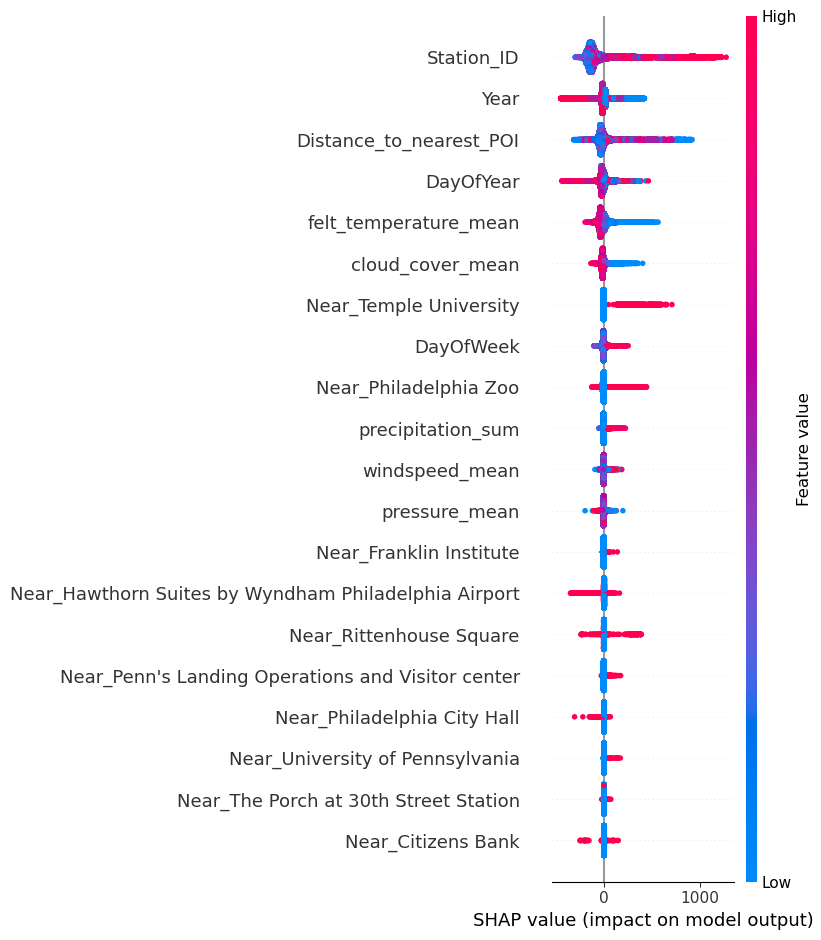

In [26]:
# Feature importance/influence analysis

# Initialize JavaScript for the SHAP plots
shap.initjs()

# Create an explainer object with your model and data
explainer = shap.TreeExplainer(model_xgboost_tuned, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


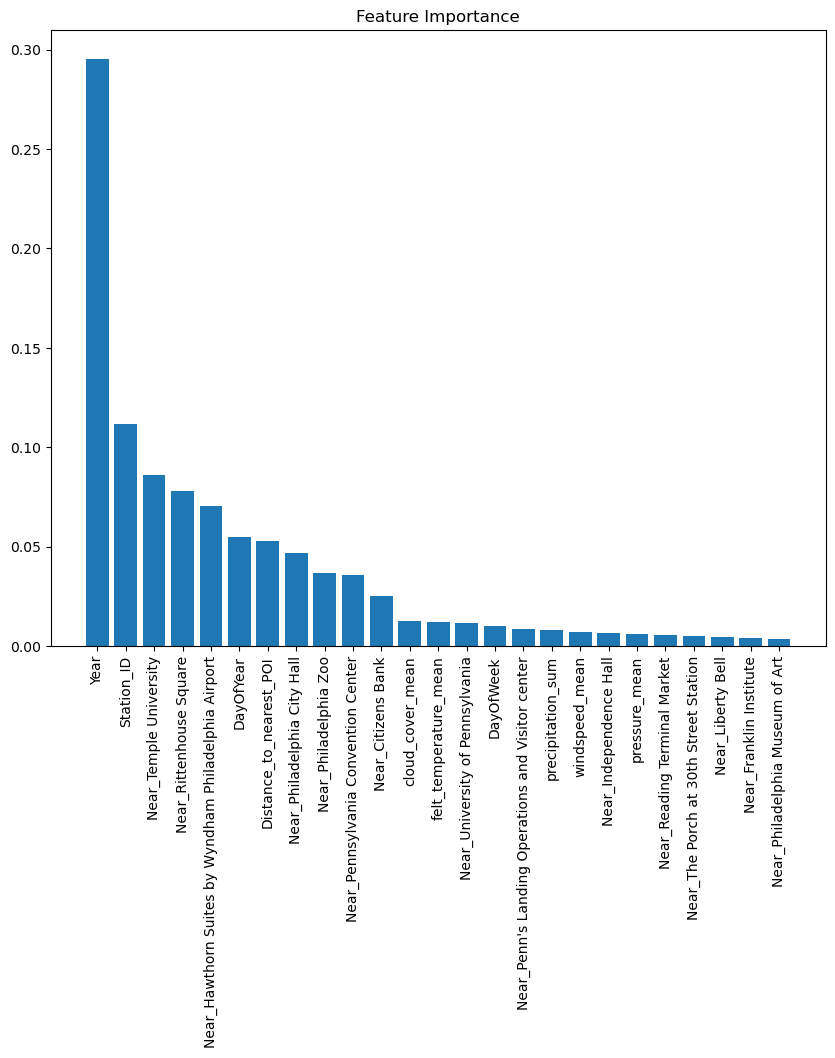

In [27]:
# Plot feature importance
def plot_feature_importances(model, feature_names):
    # Get feature importances from the model
    importances = model_xgboost_tuned.feature_importances_

    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange the feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.title("Feature Importance")

    # Add the bars
    plt.bar(range(X.shape[1]), importances[indices])

    # Add the feature names as x-axis labels
    plt.xticks(range(X.shape[1]), names, rotation=90)

    # Show the plot
    plt.show()

plot_feature_importances(model_xgboost, X_train.columns)